In [1]:
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.arima_process import ArmaProcess
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.stattools import adfuller
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

import warnings
warnings.filterwarnings('ignore')

%matplotlib inline

In [2]:
df = pd.read_csv('data/foot_traffic.csv')

df.head()

,foot_traffic
0,500.496714
1,500.522366
2,501.426876
3,503.295990
4,504.132695


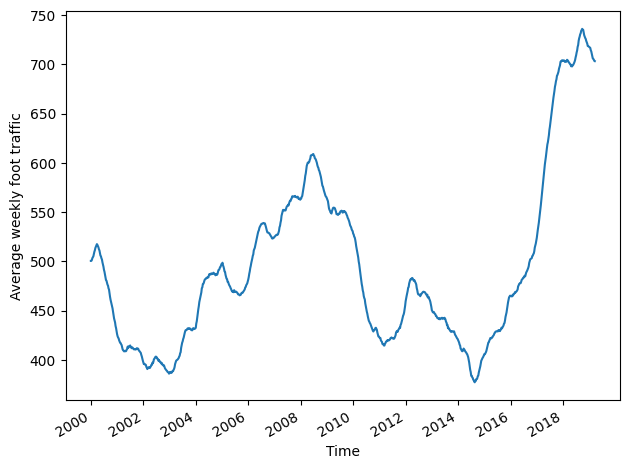

In [3]:
fig, ax = plt.subplots()

ax.plot(df['foot_traffic'])
ax.set_xlabel('Time')
ax.set_ylabel('Average weekly foot traffic')

plt.xticks(np.arange(0, 1000, 104), np.arange(2000, 2020, 2))

fig.autofmt_xdate()
plt.tight_layout()

plt.savefig('figures/CH05_F01_peixeiro.png', dpi=300)

In [4]:
ADF_result = adfuller(df['foot_traffic'])

print(f'ADF Statistic: {ADF_result[0]}')
print(f'p-value: {ADF_result[1]}')

ADF Statistic: -1.17588859992407
p-value: 0.6838808917896209


In [5]:
foot_traffic_diff = np.diff(df['foot_traffic'], n=1)

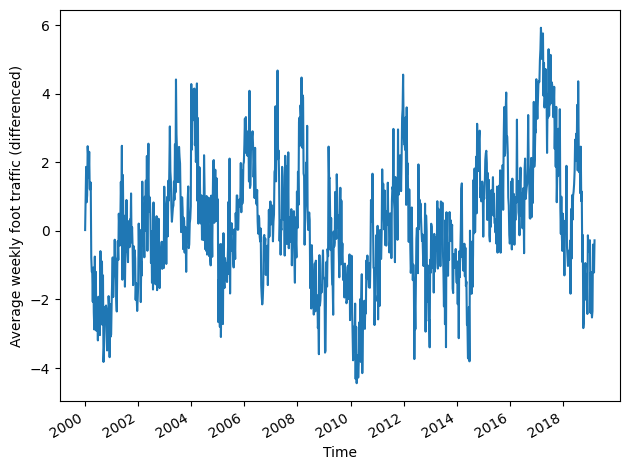

In [6]:
fig, ax = plt.subplots()

ax.plot(foot_traffic_diff)
ax.set_xlabel('Time')
ax.set_ylabel('Average weekly foot traffic (differenced)')

plt.xticks(np.arange(0, 1000, 104), np.arange(2000, 2020, 2))

fig.autofmt_xdate()
plt.tight_layout()

plt.savefig('figures/CH05_F05_peixeiro.png', dpi=300)

In [7]:
ADF_result = adfuller(foot_traffic_diff)

print(f'ADF Statistic: {ADF_result[0]}')
print(f'p-value: {ADF_result[1]}')

ADF Statistic: -5.268231347422048
p-value: 6.369317654781179e-06


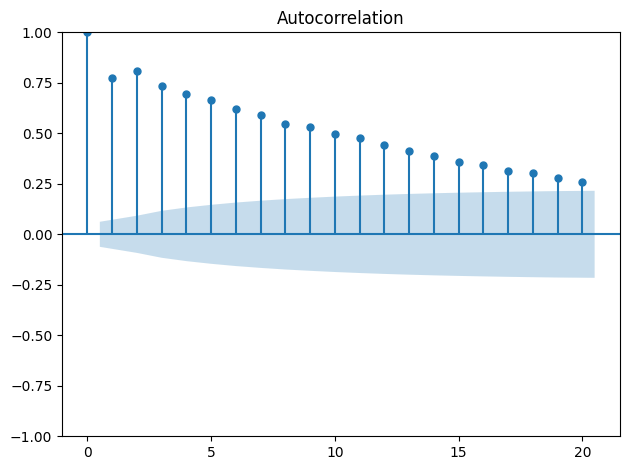

In [8]:
plot_acf(foot_traffic_diff, lags=20);

plt.tight_layout()

plt.savefig('figures/CH05_F06_peixeiro.png', dpi=300)

## Simulation 

In [9]:
from statsmodels.tsa.arima_process import ArmaProcess
import numpy as np

np.random.seed(42)

ma2 = np.array([1, 0, 0])
ar2 = np.array([1, -0.33, -0.50])

AR2_process = ArmaProcess(ar2, ma2).generate_sample(nsample=1000)

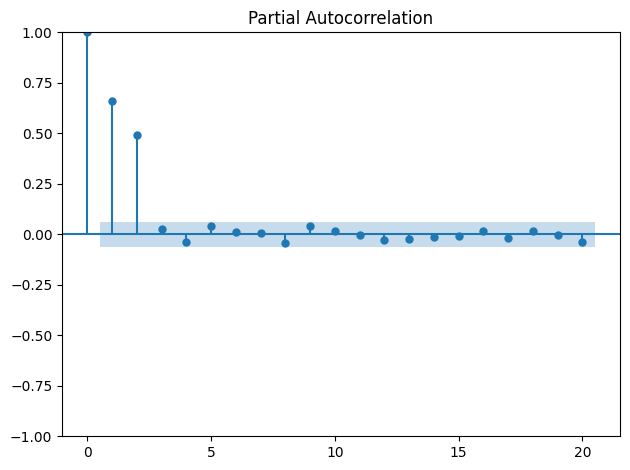

In [10]:
from statsmodels.graphics.tsaplots import plot_pacf

plot_pacf(AR2_process, lags=20);

plt.tight_layout()

plt.savefig('figures/CH05_F07_peixeiro.png', dpi=300)

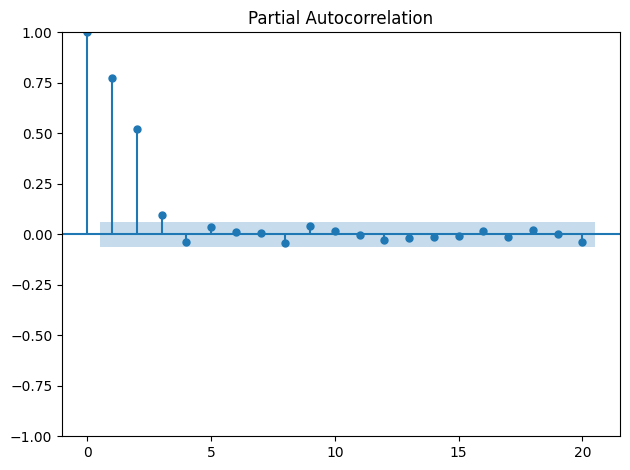

In [11]:
plot_pacf(foot_traffic_diff, lags=20);

plt.tight_layout()

plt.savefig('figures/CH05_F08_peixeiro.png', dpi=300)

In [12]:
df_diff = pd.DataFrame({'foot_traffic_diff': foot_traffic_diff})

train = df_diff[:-52]
test = df_diff[-52:]

print(len(train))
print(len(test))

947
52


In [13]:
test

,foot_traffic_diff
947,-0.776601
948,-0.574631
949,-0.890697
950,-0.283552
951,-1.830685
952,0.635514
953,-0.807623
954,1.040389
955,0.326728
956,1.028235


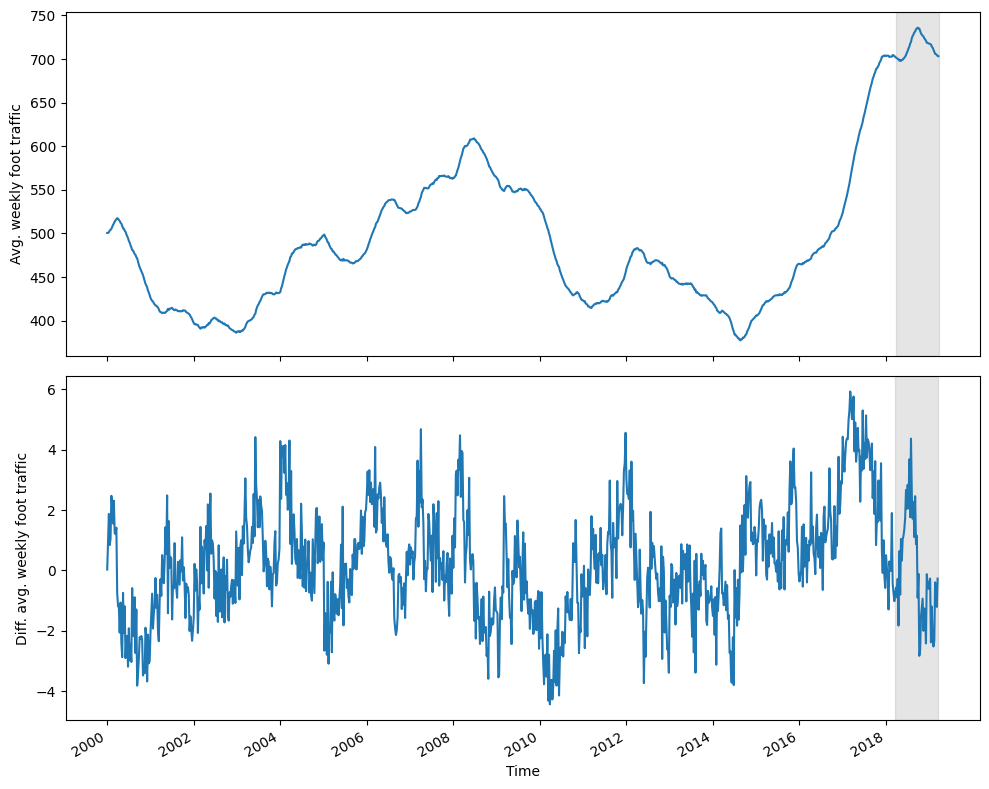

In [14]:
fig, (ax1, ax2) = plt.subplots(nrows=2, ncols=1, sharex=True, figsize=(10, 8))

ax1.plot(df['foot_traffic'])
ax1.set_xlabel('Time')
ax1.set_ylabel('Avg. weekly foot traffic')
ax1.axvspan(948, 1000, color='#808080', alpha=0.2)

ax2.plot(df_diff['foot_traffic_diff'])
ax2.set_xlabel('Time')
ax2.set_ylabel('Diff. avg. weekly foot traffic')
ax2.axvspan(947, 999, color='#808080', alpha=0.2)

plt.xticks(np.arange(0, 1000, 104), np.arange(2000, 2020, 2))

fig.autofmt_xdate()
plt.tight_layout()

plt.savefig('figures/CH05_F09_peixeiro.png', dpi=300)

In [15]:
def rolling_forecast(df: pd.DataFrame, train_len: int, horizon: int, window: int, method: str) -> list:
    
    total_len = train_len + horizon
    end_idx = train_len
    
    if method == 'mean':
        pred_mean = []
        
        for i in range(train_len, total_len, window):
            mean = np.mean(df[:i].values)
            pred_mean.extend(mean for _ in range(window))
            
        return pred_mean

    elif method == 'last':
        pred_last_value = []
        
        for i in range(train_len, total_len, window):
            last_value = df[:i].iloc[-1].values[0]
            pred_last_value.extend(last_value for _ in range(window))
            
        return pred_last_value
    
    elif method == 'AR':
        pred_AR = []
        
        for i in range(train_len, total_len, window):
            model = SARIMAX(df[:i], order=(3,0,0))
            res = model.fit(disp=False)
            predictions = res.get_prediction(0, i + window - 1)
            oos_pred = predictions.predicted_mean.iloc[-window:]
            pred_AR.extend(oos_pred)
            
        return pred_AR

In [16]:
TRAIN_LEN = len(train)
HORIZON = len(test)
WINDOW = 1

pred_mean = rolling_forecast(df_diff, TRAIN_LEN, HORIZON, WINDOW, 'mean')
pred_last_value = rolling_forecast(df_diff, TRAIN_LEN, HORIZON, WINDOW, 'last')
pred_AR = rolling_forecast(df_diff, TRAIN_LEN, HORIZON, WINDOW, 'AR')

test['pred_mean'] = pred_mean
test['pred_last_value'] = pred_last_value
test['pred_AR'] = pred_AR

test.head()

,foot_traffic_diff,pred_mean,pred_last_value,pred_AR
947,-0.776601,0.213270,-1.021893,-0.719714
948,-0.574631,0.212226,-0.776601,-0.814547
949,-0.890697,0.211397,-0.574631,-0.664738
950,-0.283552,0.210237,-0.890697,-0.641469
951,-1.830685,0.209717,-0.283552,-0.579279


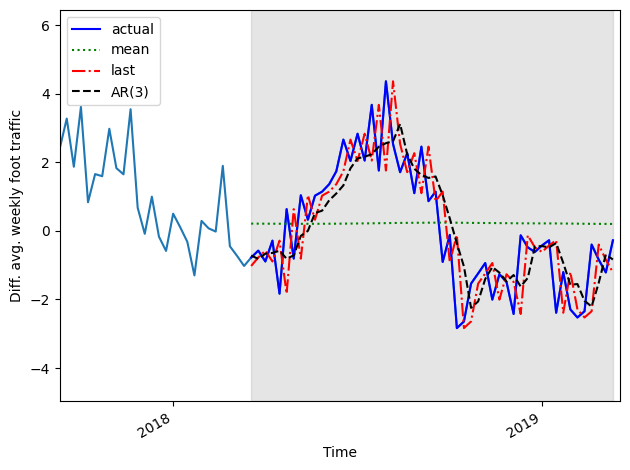

In [17]:
fig, ax = plt.subplots()

ax.plot(df_diff['foot_traffic_diff'])
ax.plot(test['foot_traffic_diff'], 'b-', label='actual')
ax.plot(test['pred_mean'], 'g:', label='mean')
ax.plot(test['pred_last_value'], 'r-.', label='last')
ax.plot(test['pred_AR'], 'k--', label='AR(3)')

ax.legend(loc=2)

ax.set_xlabel('Time')
ax.set_ylabel('Diff. avg. weekly foot traffic')

ax.axvspan(947, 998, color='#808080', alpha=0.2)

ax.set_xlim(920, 999)

plt.xticks([936, 988],[2018, 2019])

fig.autofmt_xdate()
plt.tight_layout()

plt.savefig('figures/CH05_F10_peixeiro.png', dpi=300)

In [18]:
from sklearn.metrics import mean_squared_error

mse_mean = mean_squared_error(test['foot_traffic_diff'], test['pred_mean'])
mse_last = mean_squared_error(test['foot_traffic_diff'], test['pred_last_value'])
mse_AR = mean_squared_error(test['foot_traffic_diff'], test['pred_AR'])

print(mse_mean, mse_last, mse_AR)

3.1079979374701447 1.448730118495964 0.924247916269067


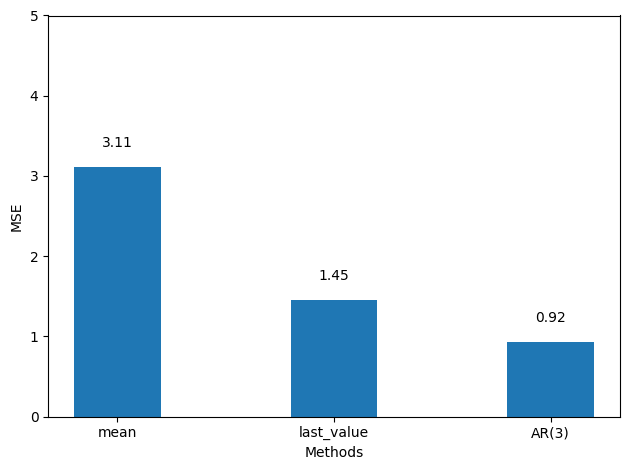

In [19]:
fig, ax = plt.subplots()

x = ['mean', 'last_value', 'AR(3)']
y = [mse_mean, mse_last, mse_AR]

ax.bar(x, y, width=0.4)
ax.set_xlabel('Methods')
ax.set_ylabel('MSE')
ax.set_ylim(0, 5)

for index, value in enumerate(y):
    plt.text(x=index, y=value+0.25, s=str(round(value, 2)), ha='center')

plt.tight_layout()

In [20]:
test

,foot_traffic_diff,pred_mean,pred_last_value,pred_AR
947,-0.776601,0.213270,-1.021893,-0.719714
948,-0.574631,0.212226,-0.776601,-0.814547
949,-0.890697,0.211397,-0.574631,-0.664738
950,-0.283552,0.210237,-0.890697,-0.641469
951,-1.830685,0.209717,-0.283552,-0.579279
952,0.635514,0.207574,-1.830685,-0.810733
953,-0.807623,0.208023,0.635514,-0.713463
954,1.040389,0.206959,-0.807623,-0.144974
955,0.326728,0.207831,1.040389,0.002759
956,1.028235,0.207956,0.326728,0.520063


In [21]:
df.iloc[948]

foot_traffic    701.68683
Name: 948, dtype: float64

In [22]:
df.iloc[947]

foot_traffic    702.46343
Name: 947, dtype: float64

In [23]:
df['foot_traffic'].iloc[948] - df['foot_traffic'].iloc[947]

-0.776600609794059

In [24]:
df['pred_foot_traffic'] = pd.Series()
df['reverse_diff'] = pd.Series()
# ORIGINAL
#df['pred_foot_traffic'][948:] = df['foot_traffic'].iloc[948] + test['pred_AR'].cumsum()
df['pred_foot_traffic'][948:] = df['foot_traffic'].iloc[947] + test['pred_AR'].cumsum()



In [ ]:
# Ne bavimo se predikcijama, nego vraćamo differencirano na originalnu skalu.
# Ako mi logika štima i iloc treba biti jedan manji od navedenog, reverse diff bi trebao u retku bit jednak početnoj foot traffic vrijednosti
df['reverse_diff'][948:] = df['foot_traffic'].iloc[947] + test['foot_traffic_diff'].cumsum()

In [25]:
df[948:]

,foot_traffic,pred_foot_traffic,reverse_diff
948,701.686830,701.743716,701.68683
949,701.112198,700.929169,701.112198
950,700.221501,700.264431,700.221501
951,699.937948,699.622962,699.937948
952,698.107264,699.043684,698.107264
953,698.742777,698.23295,698.742777
954,697.935155,697.519487,697.935155
955,698.975544,697.374513,698.975544
956,699.302273,697.377273,699.302273
957,700.330507,697.897335,700.330507


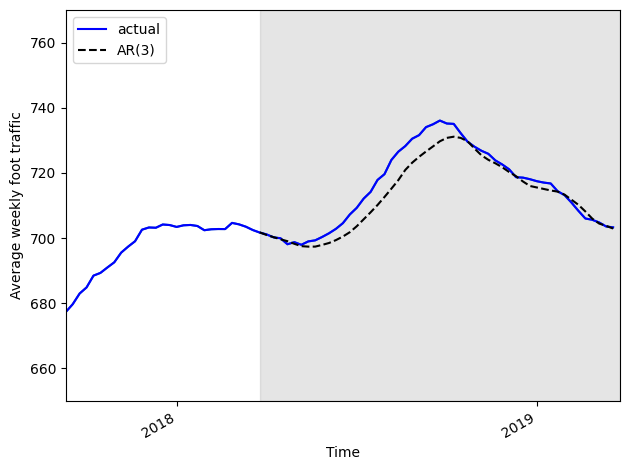

In [26]:
fig, ax = plt.subplots()

ax.plot(df['foot_traffic'])
ax.plot(df['foot_traffic'], 'b-', label='actual')
ax.plot(df['pred_foot_traffic'], 'k--', label='AR(3)')

ax.legend(loc=2)

ax.set_xlabel('Time')
ax.set_ylabel('Average weekly foot traffic')

ax.axvspan(948, 1000, color='#808080', alpha=0.2)

ax.set_xlim(920, 1000)
ax.set_ylim(650, 770)

plt.xticks([936, 988],[2018, 2019])

fig.autofmt_xdate()
plt.tight_layout()

plt.savefig('figures/CH05_F11_peixeiro.png', dpi=300)

In [27]:
from sklearn.metrics import mean_absolute_error

mae_AR_undiff = mean_absolute_error(df['foot_traffic'][948:], df['pred_foot_traffic'][948:])

print(mae_AR_undiff)

2.8687972947437004
